In [229]:
import numpy as np
import copy
import matplotlib.pyplot as plt

import scipy
from scipy import signal,stats
from scipy.fft import rfft,rfftfreq
from scipy.ndimage import uniform_filter1d

import seaborn as sns
import pandas as pd
import sklearn
import seaborn as sns

In [ ]:
# # Create function to load data 

filenames = ['Happy_0_Meisner.txt', 'Tense_0_Meisner.txt', 'Relaxed_9.txt', 'Sad_0_Maisner.txt'] 

filenames_antonio = ['Erotic_5.txt', 'Fear 2_1.txt', 'Scenery_2.txt', 'Sadness_7.txt']

luisa_eoec_filenames = ['E0_1.txt', 'EC_1.txt', 'EO_2.txt', 'EC_2.txt']

antonio_eoec_filenames = ['EO_1.txt', 'EC_1.txt', 'EO_2.txt', 'EC_2.txt']

luisa_data = {'Happy':[],
              'Tense':[],
              'Relaxed':[],
              'Sad':[]}

luisa_eoec_data = {'EO1':[],
              'EC1':[],
              'EO2':[],
              'EC2':[]}

antonio_data = {'Happy':[],
              'Tense':[],
              'Relaxed':[],
              'Sad':[]}

antonio_eoec_data = {'EO1':[],
              'EC1':[],
              'EO2':[],
              'EC2':[]}


channels = ['0','1','2','3']

def load_data(file_path):
    data_file = pd.read_csv(file_path, comment='%', header=0, delimiter=',', engine='python') 
    data = data_file[[' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', ' EXG Channel 3']].values.T
    return data

# # Load Luisa data
print('Luisa Data:\n')
for idx, (state, _) in enumerate(luisa_data.items()):
    luisa_data[state] = load_data(f'.../Subject 6 Luisa/{filenames[idx]}')
    print(f'{state} Data Shape: {luisa_data[state].shape}')

print('\nLuisa EOEC Data:\n')
for i,eyes in enumerate(luisa_eoec_data.keys()):
    luisa_eoec_data[eyes] = load_data(f'.../Subject 6 Luisa/{luisa_eoec_filenames[i]}')
    print(f'{eyes} Data Shape: {luisa_eoec_data[eyes].shape}')

# # Load Antonio data
print('\nAntonio Data:\n')
for idx, (state, _) in enumerate(antonio_data.items()):
    antonio_data[state] = load_data(f'.../Subject 3 Antonio/{filenames_antonio[idx]}')
    print(f'{state} Data Shape: {antonio_data[state].shape}')

antonio_data = {state : antonio_data[state][:,int(20*256):] for state in antonio_data.keys()} # Remove first 10 seconds of antonio data (artifact)

print('\nAntonio EOEC Data:\n')
for i,eyes in enumerate(antonio_eoec_data.keys()):
    antonio_eoec_data[eyes] = load_data(f'.../Subject 3 Antonio/{antonio_eoec_filenames[i]}')
    print(f'{eyes} Data Shape: {antonio_eoec_data[eyes].shape}')



Luisa Data:

Happy Data Shape: (4, 18883)
Tense Data Shape: (4, 37779)
Relaxed Data Shape: (4, 18036)
Sad Data Shape: (4, 45879)

Luisa EOEC Data:

EO1 Data Shape: (4, 13339)
EC1 Data Shape: (4, 12326)
EO2 Data Shape: (4, 12881)
EC2 Data Shape: (4, 13204)

Antonio Data:

Happy Data Shape: (4, 24452)
Tense Data Shape: (4, 26844)
Relaxed Data Shape: (4, 26677)
Sad Data Shape: (4, 24321)

Antonio EOEC Data:

EO1 Data Shape: (4, 12181)
EC1 Data Shape: (4, 13234)
EO2 Data Shape: (4, 12272)
EC2 Data Shape: (4, 12312)


In [231]:
# # Remove outliers by using interpolation

for state, data in luisa_data.items():
    for i, ch in enumerate(data):
        luisa_mask = abs(ch - np.mean(ch)) > 2 * np.std(ch) # Identify outliers
        
        # Replace outliers using linear interpolation
        indices = np.arange(len(ch)) 
        ch_cleaned = np.copy(ch)
        ch_cleaned[luisa_mask] = np.interp(indices[luisa_mask], indices[~luisa_mask], ch[~luisa_mask])
        
        luisa_data[state][i] = ch_cleaned

for state, data in antonio_data.items():
    for i, ch in enumerate(data):
        antonio_mask = abs(ch - np.mean(ch)) > 2 * np.std(ch) 
        
        indices = np.arange(len(ch)) 
        ch_cleaned = np.copy(ch)
        ch_cleaned[antonio_mask] = np.interp(indices[antonio_mask], indices[~antonio_mask], ch[~antonio_mask])
        
        antonio_data[state][i] = ch_cleaned


In [232]:
# # Set sampling frequency
fs = 200

# Apply a bandpass filter between 4-55 Hz to each set of data
filt_coef = signal.firwin(numtaps=(int(3*fs/4)), cutoff=(4,55), fs=fs, pass_zero=False)

# # Filter luisa data
for state, data in luisa_data.items():
    luisa_data[state] = signal.lfilter(filt_coef,1.0,data, axis=-1)

for eyes, data in luisa_eoec_data.items():
    luisa_eoec_data[eyes] = signal.lfilter(filt_coef,1.0,data, axis=-1)

# # Filter antonio data
for state, data in antonio_data.items():
    antonio_data[state] = signal.lfilter(filt_coef,1.0,data, axis=-1)

for eyes, data in antonio_eoec_data.items():
    antonio_eoec_data[eyes] = signal.lfilter(filt_coef,1.0,data, axis=-1)



In [233]:
# # Grab the right mastoid region data only from Luisa and Antonio and chop out first half ********

luisa_data_rm = {state : luisa_data[state][0,data.shape[1]//2:] for state,data in luisa_data.items()}

antonio_data_rm = {state : antonio_data[state][0,data.shape[1]//2:] for state,data in antonio_data.items()}

print(luisa_data_rm['Happy'].shape)

# EOEC Data

luisa_data_rm_eoec = {eyes : luisa_eoec_data[eyes][0,data.shape[1]//2:] for eyes,data in luisa_eoec_data.items()}

antonio_data_rm_eoec = {eyes : antonio_eoec_data[eyes][0,data.shape[1]//2:] for eyes,data in antonio_eoec_data.items()}


(9442,)


In [234]:
# # Create plotting functon for time and freq domain and plot Luisa data
def plot_subject_freq_data(data,fs,channels,title,power_ylim=None):

    n_states = len(data)
    fig, ax = plt.subplots(n_states,1, figsize=(12,10))
    fig.suptitle(f"{title}", fontsize=16,fontweight='bold')
    colors=['Orange','Red','Cyan','Purple']

    for row, (state, data) in enumerate(data.items()):

        # Plot frequency domain data (power spectrum)
        ft = abs(rfft(data))
        ps = ft**2
        freqs = rfftfreq(data.size, d=1/fs)
        
        ax[row].plot(freqs, ps, label=f'{state}', color=colors[row])
        ax[row].set_xlabel('Frequency (Hz)', fontsize=10,fontweight='bold')
        ax[row].set_ylabel('Power (Log Scale)', fontsize=10,fontweight='bold')
        ax[row].set_xlim([4, 60])
        ax[row].legend()
        ax[row].set_yscale('log')
        ax[row].grid(True, which='major')
        if power_ylim:
            ax[row].set_ylim(power_ylim) 
        ax[row].tick_params(axis='both', which='major', labelsize=10)

    
    plt.tight_layout() 
    plt.show()

    return 


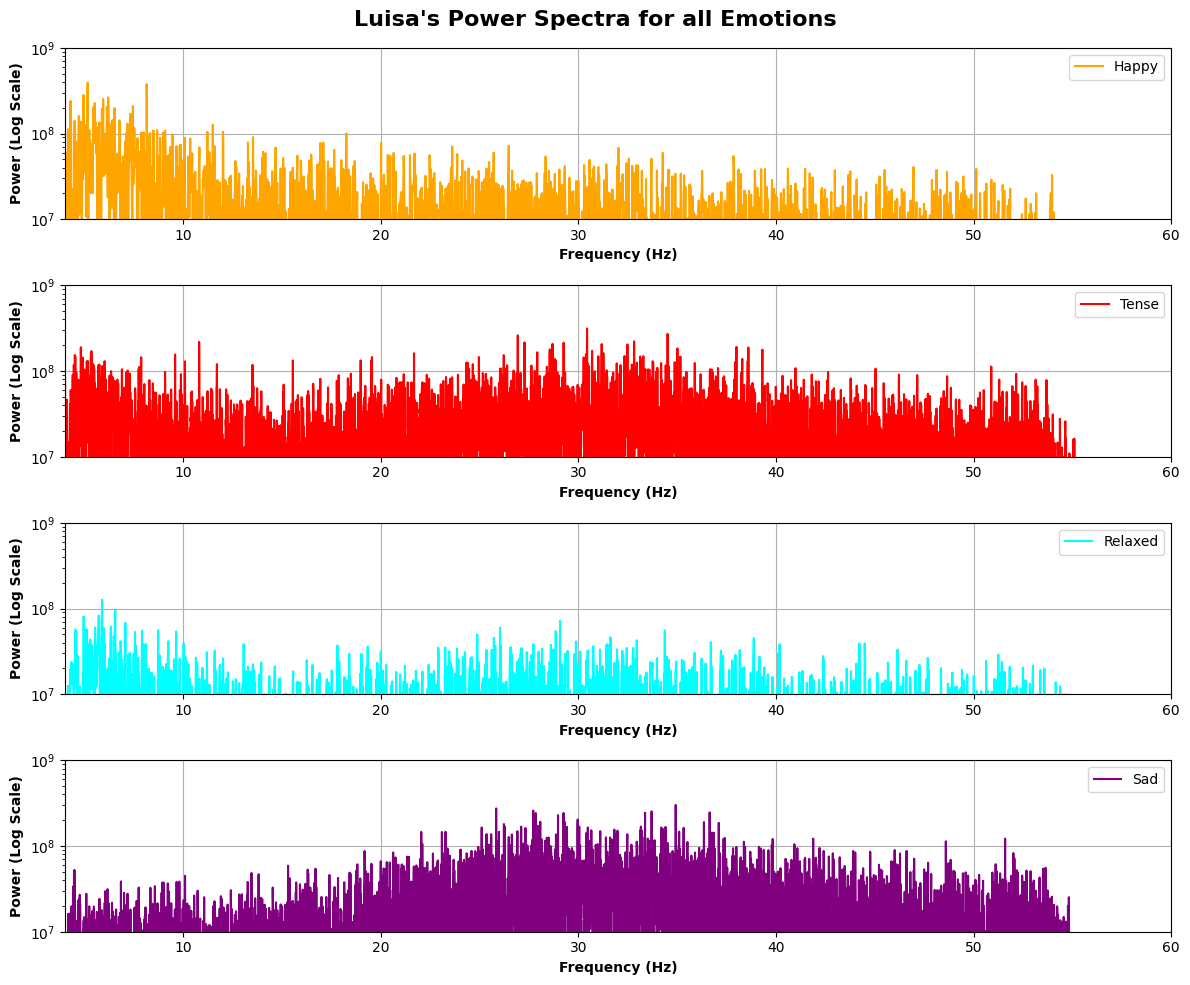

In [235]:
# # Plot luisa data
luisa_freq_data = plot_subject_freq_data(data=luisa_data_rm, fs=fs, channels=channels,
                                         title="Luisa's Power Spectra for all Emotions",power_ylim=[10e6,10e8])

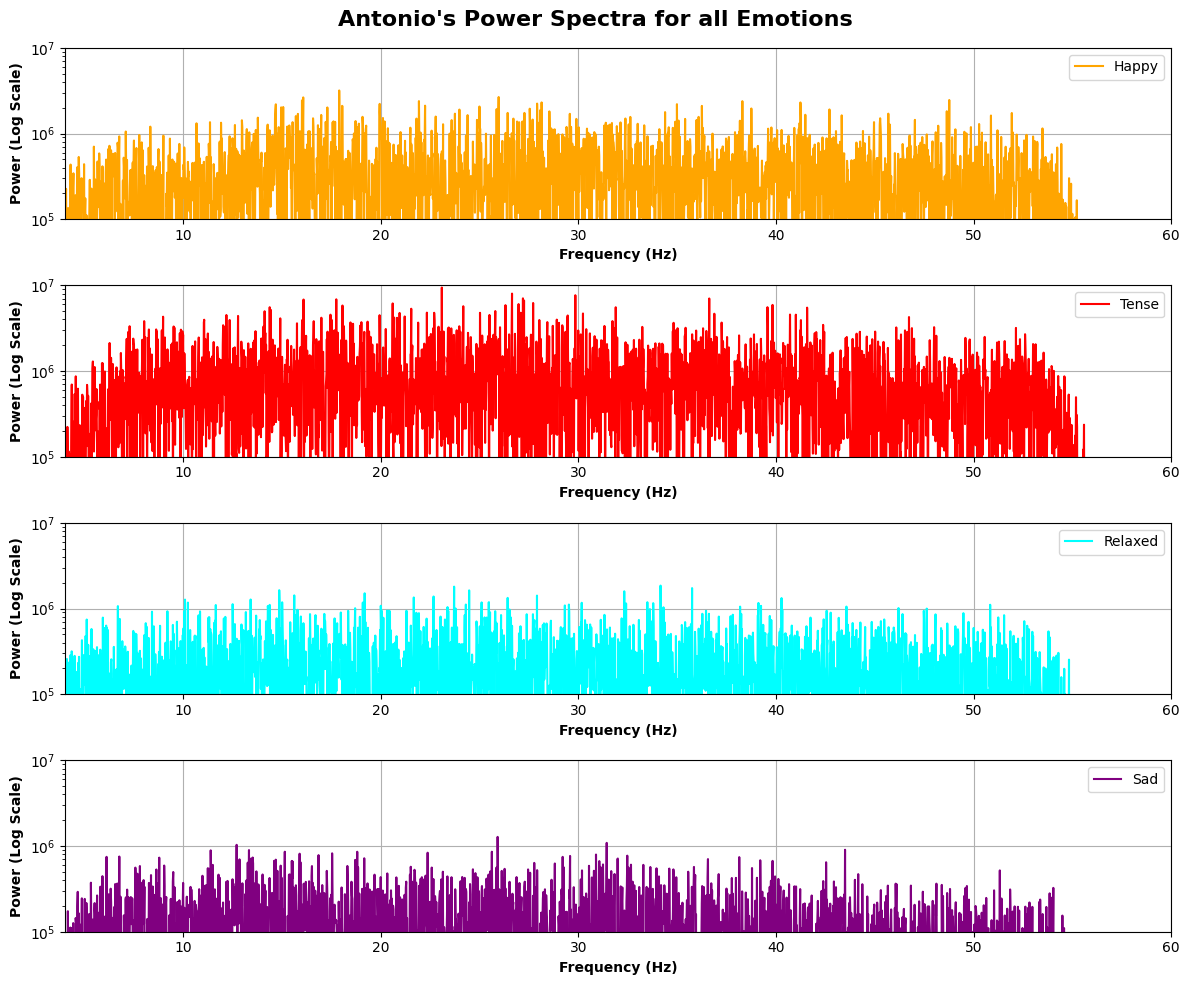

In [236]:
# # Plot antonio data
antonio_freq_data = plot_subject_freq_data(data=antonio_data_rm, fs=fs, channels=channels,
                                           title="Antonio's Power Spectra for all Emotions",power_ylim=[10e4,10e6])

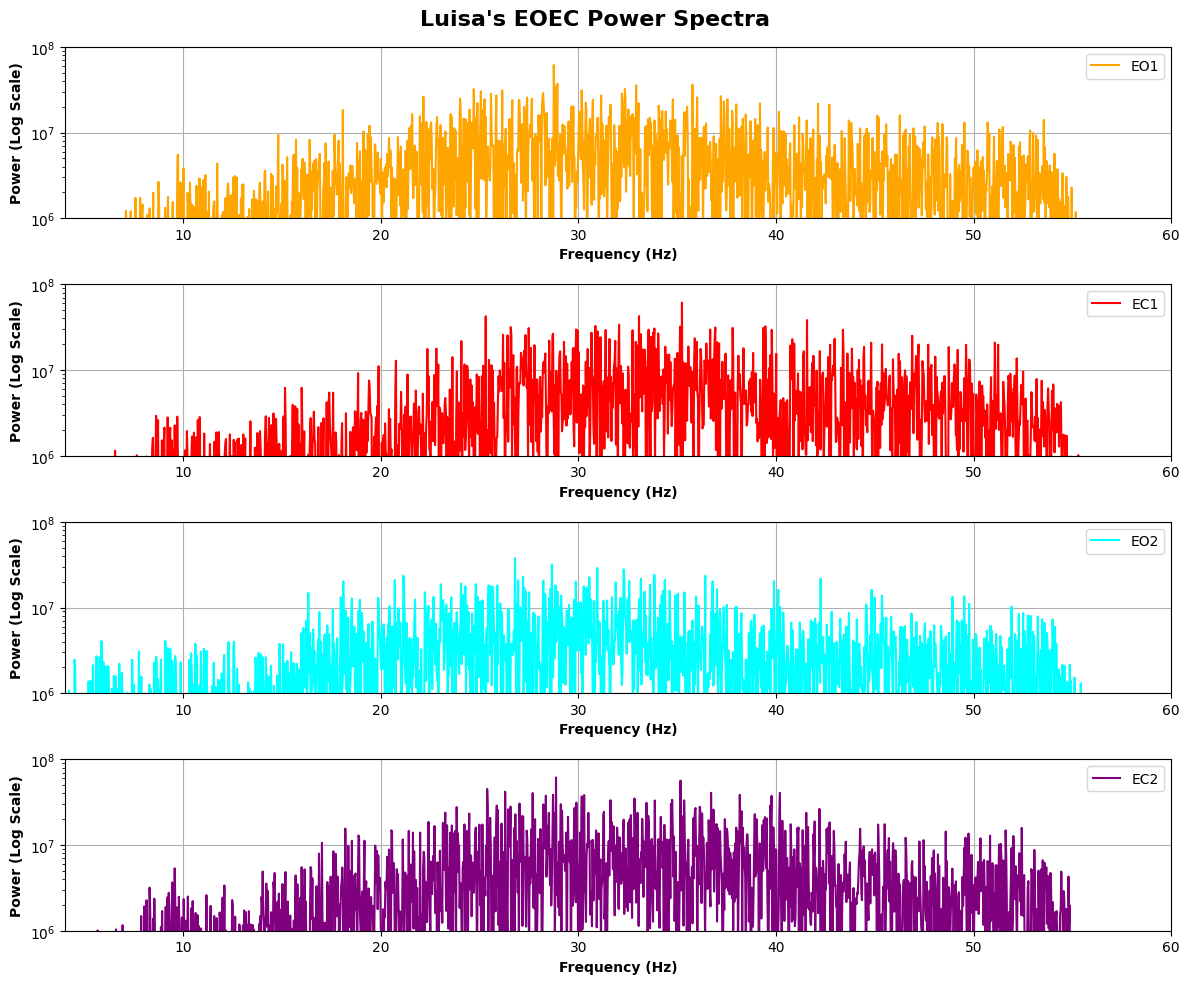

In [237]:
# # Luisa EOEC Power Spectra

luisa_eoec_freq_data = plot_subject_freq_data(data=luisa_data_rm_eoec, fs=fs, channels=channels,
                                         title="Luisa's EOEC Power Spectra",power_ylim=[10e5,10e7])

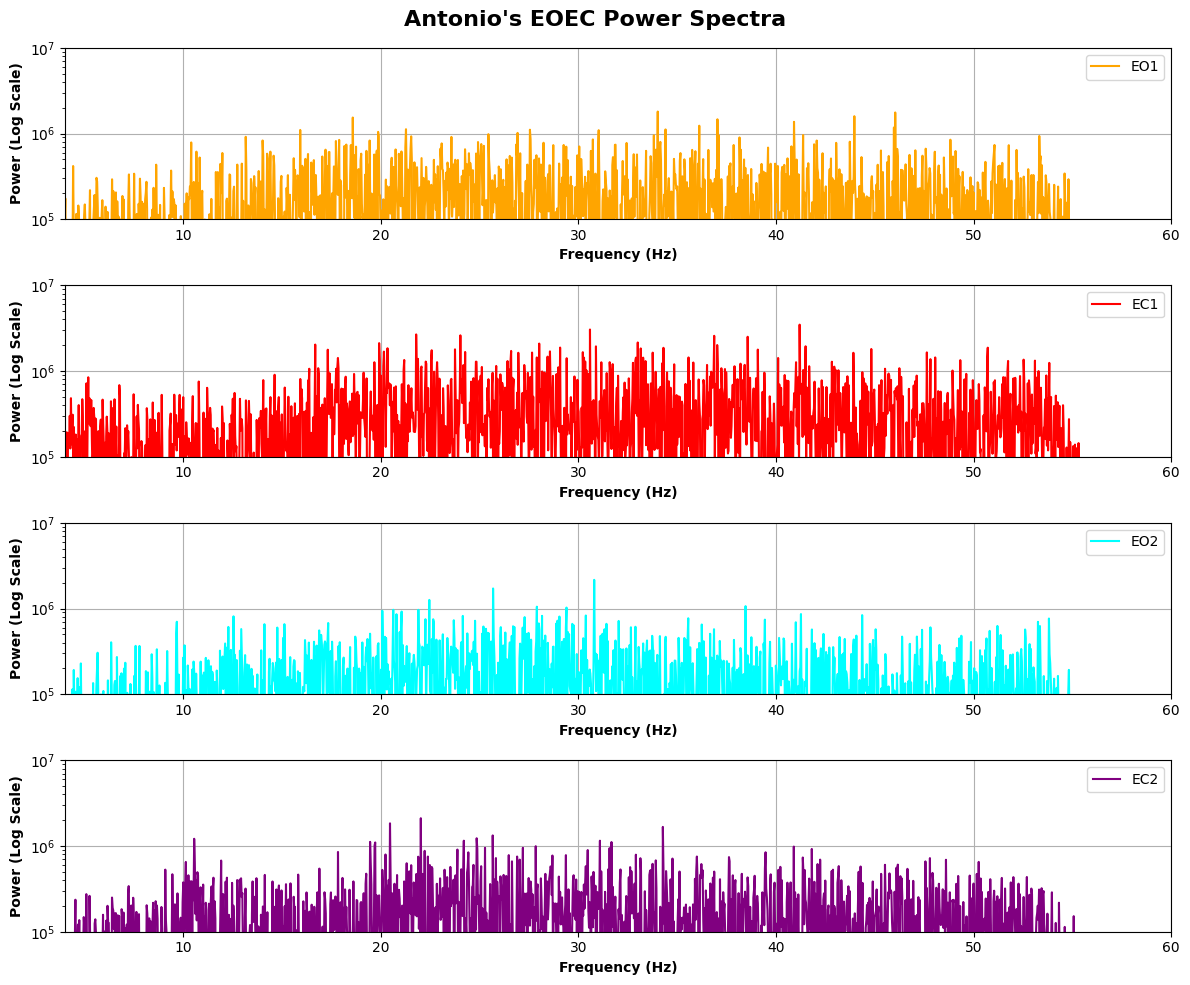

In [238]:
# # Antonio EOEC Power Spectra

antonio_eoec_freq_data = plot_subject_freq_data(data=antonio_data_rm_eoec, fs=fs, channels=channels,
                                         title="Antonio's EOEC Power Spectra",power_ylim=[10e4,10e6])

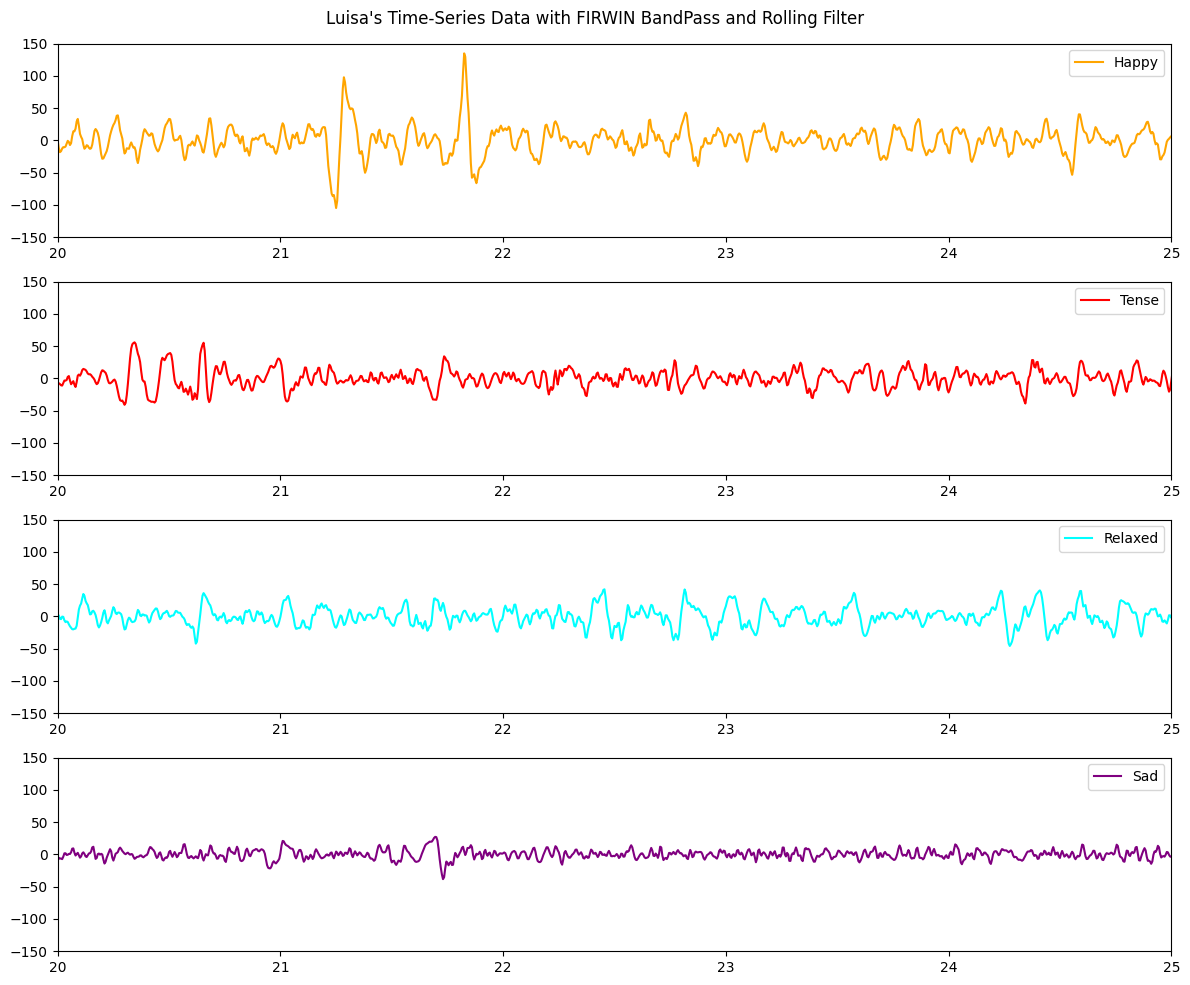

In [239]:
# Apply a rolling (moving average) filter to Luisa Data
def smooth_signal(data, window_size=6):
    return uniform_filter1d(data, size=window_size)

# Apply rolling filter to Luisa data
luisa_data_rm_roll = {state : smooth_signal(luisa_data_rm[state]) for state in luisa_data_rm.keys()} # chop out first 2 seconds

fig1,ax = plt.subplots(4,1, figsize=(12,10))
colors=['Orange','Red','Cyan','Purple']

for i, (state,data) in enumerate(luisa_data_rm_roll.items()):
    t_vect = np.arange(2, data.size/fs, 1/fs)
    ax[i].plot(t_vect,data[2*fs:], label=f"{state}", color=colors[i], lw=1.5)
    ax[i].set(xlim=[20,25], ylim=[-150,150])
    ax[i].legend()
fig1.suptitle("Luisa's Time-Series Data with FIRWIN BandPass and Rolling Filter")
plt.tight_layout()
plt.show()


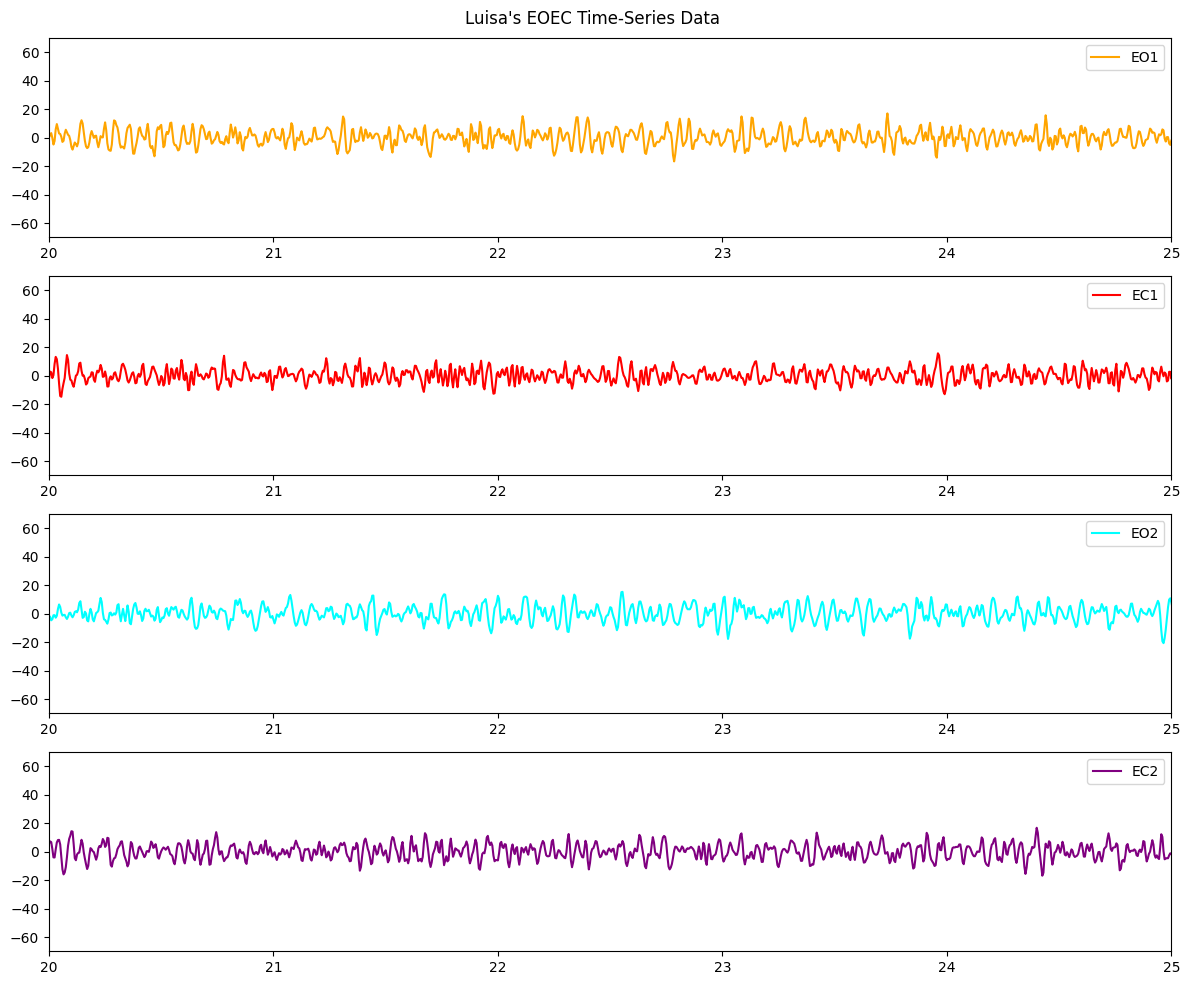

In [247]:
# Apply rolling filter to Luisa EOEC data
luisa_data_rm_eoec_roll = {eyes : smooth_signal(luisa_data_rm_eoec[eyes]) for eyes in luisa_data_rm_eoec.keys()} # chop out first 2 seconds

fig1,ax = plt.subplots(4,1, figsize=(12,10))
colors=['Orange','Red','Cyan','Purple']

for i, (eyes,data) in enumerate(luisa_data_rm_eoec_roll.items()):
    t_vect = np.arange(2, data.size/fs, 1/fs)
    ax[i].plot(t_vect,data[2*fs:], label=f"{eyes}", color=colors[i], lw=1.5)
    ax[i].set(xlim=[20,25], ylim=[-70,70]) 
    ax[i].legend()
fig1.suptitle("Luisa's EOEC Time-Series Data ")
plt.tight_layout()
plt.show()

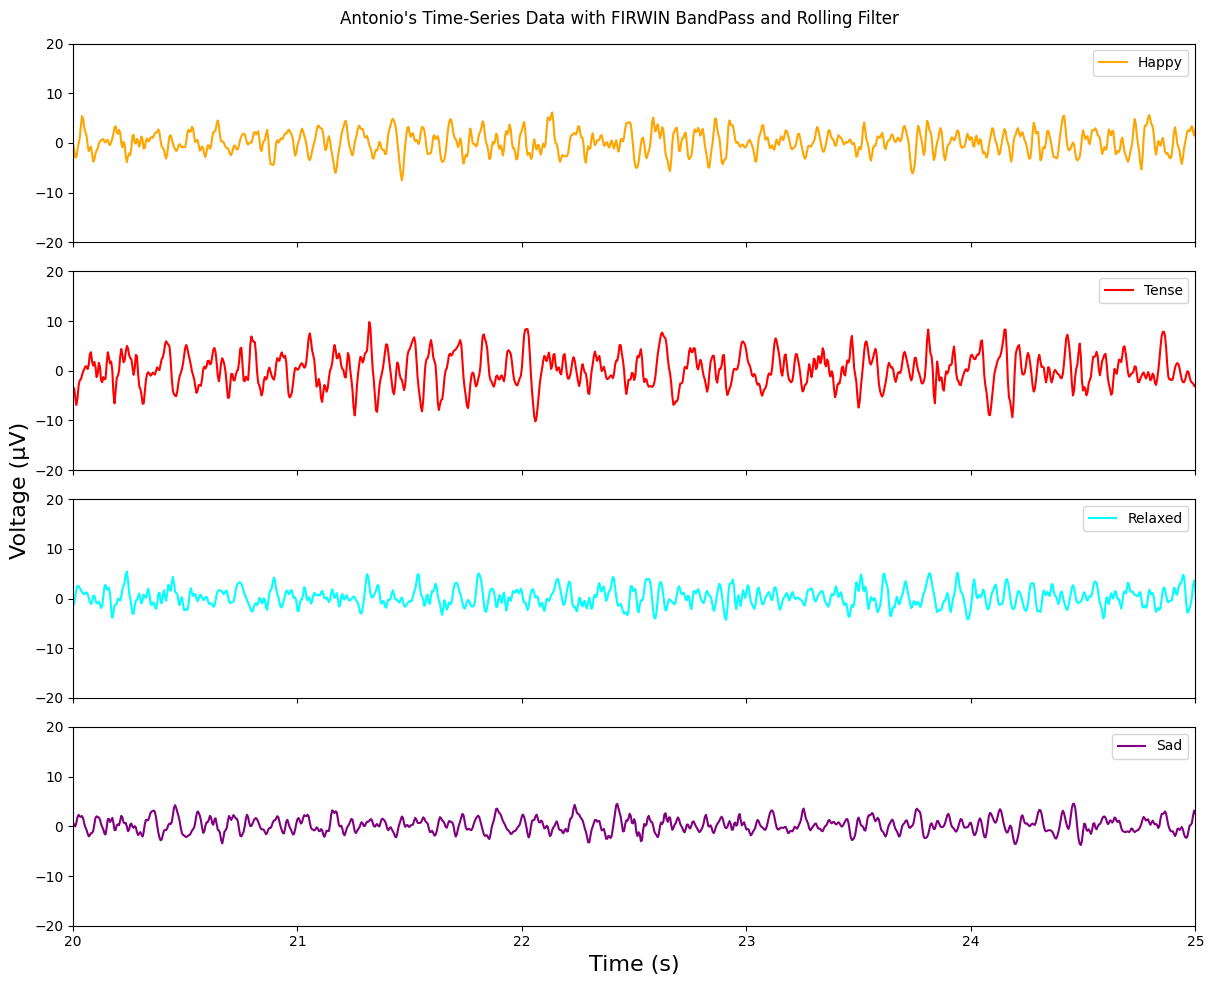

In [248]:
# # Apply rolling filter to Antonio Data
antonio_data_rm_roll = {state : smooth_signal(antonio_data_rm[state]) for state in antonio_data_rm.keys()} 

fig,ax = plt.subplots(4,1,figsize=(12,10),sharex=True,sharey=True)

for i, (state,data) in enumerate(antonio_data_rm_roll.items()):
    t_vect = np.arange(2, data.size/fs, 1/fs)
    ax[i].plot(t_vect,data[2*fs:], label=f"{state}", color=colors[i], lw=1.5)
    ax[i].set(xlim=[20,25], ylim=[-20,20])
    if i == 3:
        ax[i].set_xlabel('Time (s)', fontsize=16)
    ax[i].legend()

fig.suptitle("Antonio's Time-Series Data with FIRWIN BandPass and Rolling Filter")
fig.text(0.0008, 0.5, 'Voltage (μV)', va='center', ha='center', rotation='vertical', fontsize=16)

plt.tight_layout()
plt.show()

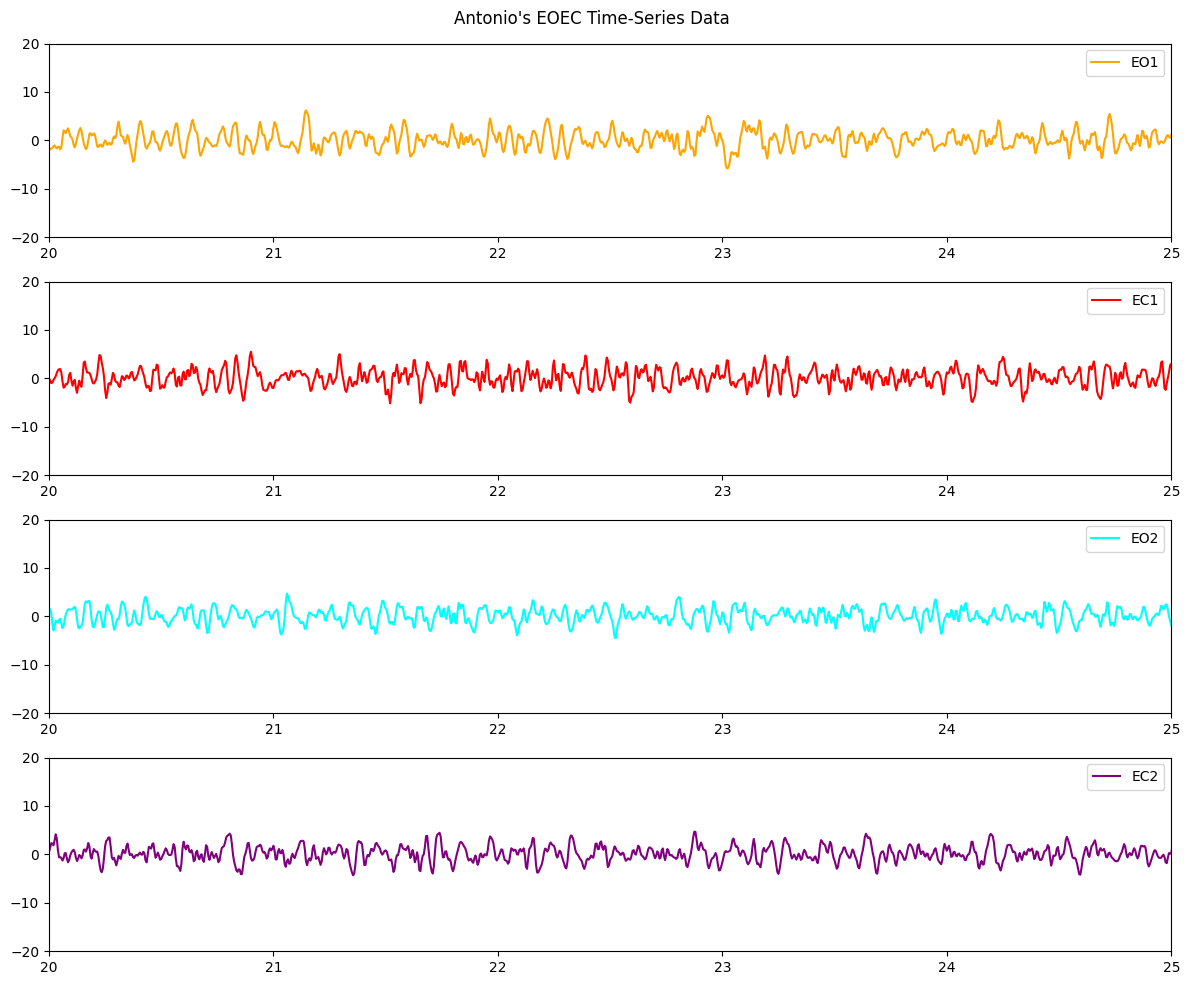

In [242]:
# Apply rolling filter to Antonio EOEC data
antonio_data_rm_eoec_roll = {eyes : smooth_signal(antonio_data_rm_eoec[eyes]) for eyes in antonio_data_rm_eoec.keys()} # chop out first 2 seconds

fig1,ax = plt.subplots(4,1, figsize=(12,10))
colors=['Orange','Red','Cyan','Purple']

for i, (eyes,data) in enumerate(antonio_data_rm_eoec_roll.items()):
    t_vect = np.arange(2, data.size/fs, 1/fs)
    ax[i].plot(t_vect,data[2*fs:], label=f"{eyes}", color=colors[i], lw=1.5)
    ax[i].set(xlim=[20,25], ylim=[-20,20])
    ax[i].legend()
fig1.suptitle("Antonio's EOEC Time-Series Data ")
plt.tight_layout()
plt.show()

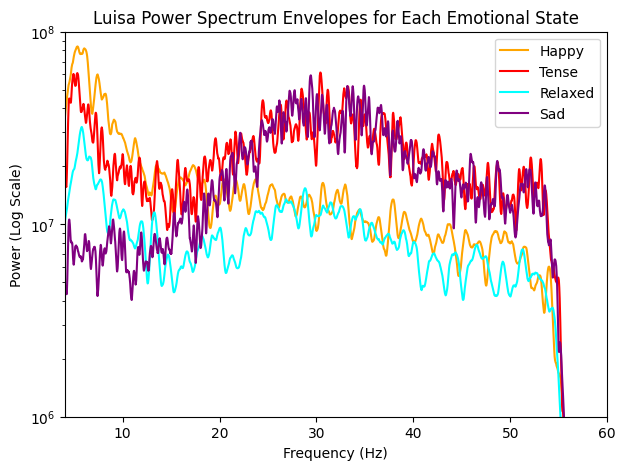

In [243]:
# # Extract signal envelope of power spectrum for Luisa and Antonio


# Function to extract the envelope using a rolling max and Savitzky-Golay filter
def extract_envelope(power_spectrum, window_size=51, poly_order=2):
    
    # Ensure window size is appropriate
    if window_size % 2 == 0:
        window_size += 1

    # Apply Savitzky-Golay filter
    envelope = signal.savgol_filter(power_spectrum, window_size, poly_order, mode='nearest')

    smooth_window = 20 
    envelope_smooth = np.convolve(envelope, np.ones(smooth_window)/smooth_window, mode='same')

    return envelope_smooth


luisa_power_spectra = {
    "Happy": [],
    "Tense": [],
    "Relaxed": [],
    "Sad": [],
}

luisa_freqs = {
    "Happy": [],
    "Tense": [],
    "Relaxed": [],
    "Sad": [],
}

for state, data in luisa_data_rm.items():
    ft = abs(rfft(data))
    luisa_power_spectra[state] = ft**2
    luisa_freqs[state] = rfftfreq(data.size, d=1/fs)

# Extract envelopes
envelopes = {state: extract_envelope(power) for state, power in luisa_power_spectra.items()}

# Plot all emotions together for visualization
fig,ax = plt.subplots(figsize=(7,5))
colors = ["orange", "red", "cyan", "purple"]

for (state, env), color in zip(envelopes.items(), colors):
    ax.plot(luisa_freqs[state], env, label=state, color=color)

ax.set_yscale("log")
ax.set(xlabel="Frequency (Hz)", ylabel= "Power (Log Scale)", 
       title= "Luisa Power Spectrum Envelopes for Each Emotional State")
ax.set(xlim=[4,60])
ax.set(ylim=[10e5,10e7])
ax.legend()

#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


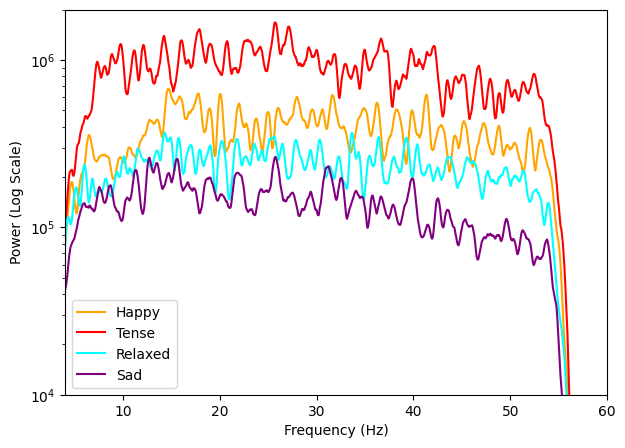

In [244]:
antonio_power_spectra = {
    "Happy": [],
    "Tense": [],
    "Relaxed": [],
    "Sad": [],
}

antonio_freqs = {
    "Happy": [],
    "Tense": [],
    "Relaxed": [],
    "Sad": [],
}

for state, data in antonio_data_rm.items():
    ft = abs(rfft(data))
    antonio_power_spectra[state] = ft**2
    antonio_freqs[state] = rfftfreq(data.size, d=1/fs)

# Extract envelopes
envelopes = {state: extract_envelope(power) for state, power in antonio_power_spectra.items()}

# Plot all emotions together for visualization
fig,ax = plt.subplots(figsize=(7,5))
colors = ["orange", "red", "cyan", "purple"]

for (state, env), color in zip(envelopes.items(), colors):
    ax.plot(antonio_freqs[state], env, label=state, color=color)

ax.set_yscale("log")
ax.set(xlabel="Frequency (Hz)", ylabel= "Power (Log Scale)")#, 
       #title= "Antonio Power Spectrum Envelopes for Each Emotional State")
ax.set(xlim=[4,60])
ax.set(ylim=[10e3,10e5+1000000])
ax.legend()

#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


In [176]:
# # Enveloped Power Spectrum Method

def eps_method(data,fs=fs):

    envelope_data = {
    "Happy": [],
    "Tense": [],
    "Relaxed": [],
    "Sad": [],
    }

    eps_data = {
    "Happy": [],
    "Tense": [],
    "Relaxed": [],
    "Sad": [],
    }

    for state,data in data.items():
        analytic_signal = signal.hilbert(data)
        envelope_data[state] = abs(analytic_signal)

    for state,data in envelope_data.items():
        freqs, psd = signal.welch(data, nperseg=int(fs),noverlap=int(fs*0.50),fs=fs)
        eps_data[state] = [freqs, psd]

    fig,ax = plt.subplots(figsize=(6,4))
    colors = ["orange", "red", "cyan", "purple"]

    for i, (state, (freqs,psd)) in enumerate(eps_data.items()):
        ax.plot(freqs,psd, label=f"{state}", color=colors[i], lw=3)
    
    ax.set_yscale("log")
    ax.set(xlabel="Frequency (Hz)", ylabel= "Power (Log Scale)", 
       title= "Luisa Power Spectrum Envelopes for Each Emotional State")
    ax.set(xlim=[4,60])
    ax.legend()

    plt.show()

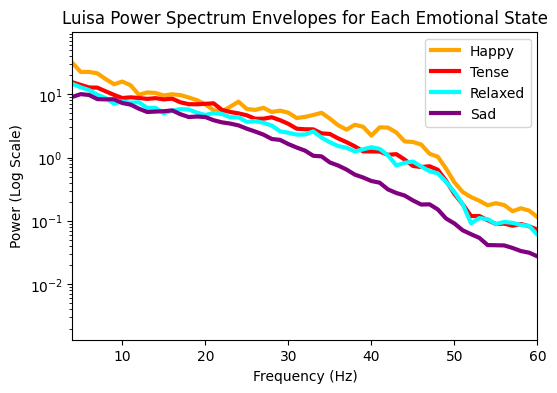

In [177]:
# # Apply EPS method to Luisa Data

eps_method(luisa_data_rm)